In [11]:
from fastai.vision.all import *
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from collections import Counter
from pathlib import Path

In [12]:
path = Path("/Users/mohammadtalha/Documents/Projects/Wickly/ml/model")  
print("data root:", path)

data root: /Users/mohammadtalha/Documents/Projects/Wickly/ml/model


In [13]:
# make candles bigger & keep mild augments
item_size = 384  # was 256; bigger so candles aren't tiny
bs = 32

chart_tfms = aug_transforms(
    do_flip=False,       # don't flip, keeps up/down context
    max_rotate=0.0,      # no rotation
    max_zoom=1.05,       # small zoom only
    max_warp=0.0,        # disable warp
    max_lighting=0.12,   # small lighting changes
    size=item_size       # match to item_size
)

dblock = DataBlock(
    blocks=(ImageBlock, MultiCategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=lambda o: [o.parent.name],
    # crop so candles fill the frame instead of padding with borders
    item_tfms=Resize(item_size, method='crop'),
    batch_tfms=chart_tfms
)

dls = dblock.dataloaders(path, bs=bs, num_workers=0)
print("vocab:", list(dls.vocab))

# quick sanity counts
all_files = get_image_files(path)
print("overall:", Counter(f.parent.name for f in all_files))
print("train:", Counter(Path(f).parent.name for f in list(dls.train.items)))
print("valid:", Counter(Path(f).parent.name for f in list(dls.valid.items)))

vocab: ['hammer', 'none']
overall: Counter({'hammer': 100, 'none': 94})
train: Counter({'hammer': 79, 'none': 77})
valid: Counter({'hammer': 21, 'none': 17})


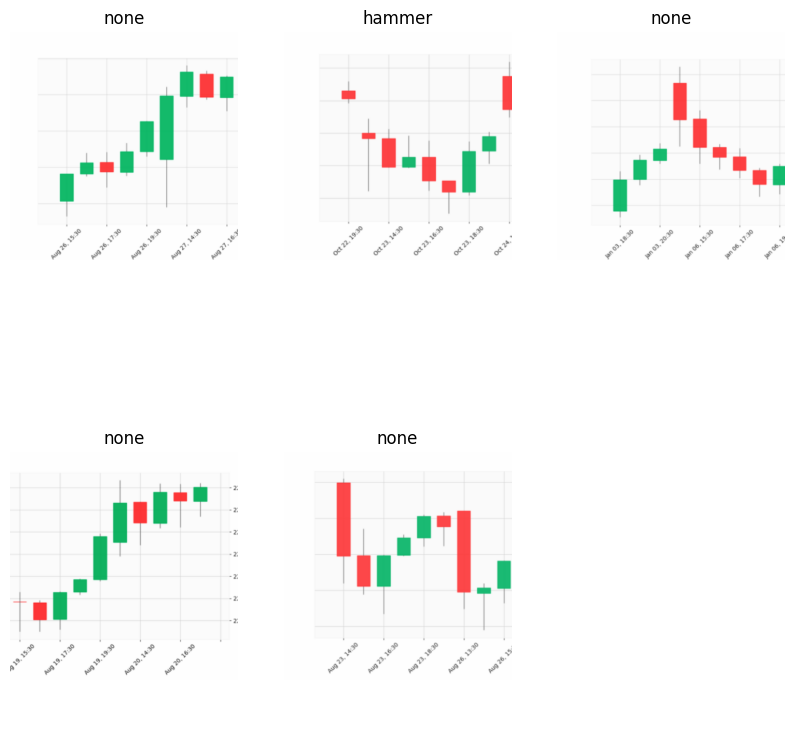

In [14]:
xb, yb = dls.one_batch()  # grabs a random batch
dls.show_batch((xb, yb), max_n=5, figsize=(10,10))

/Users/mohammadtalha/Documents/Projects/Wickly/.venv/lib/python3.11/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


/Users/mohammadtalha/Documents/Projects/Wickly/.venv/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


lr attrs available: ['count', 'index', 'valley']
using lr: 0.001737800776027143


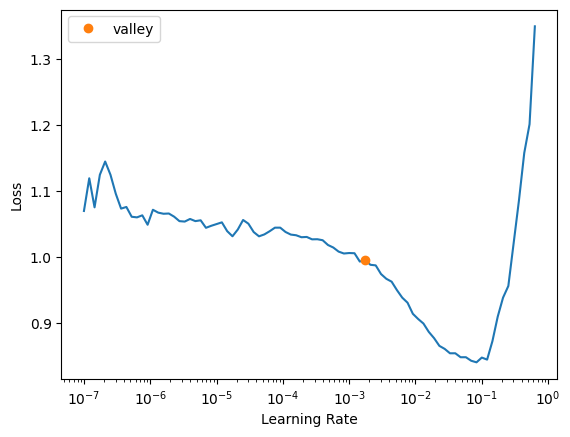

In [15]:
learn = cnn_learner(dls, resnet34, metrics=None)

lr_res = learn.lr_find()
print("lr attrs available:", [a for a in dir(lr_res) if not a.startswith('_')])

# Prefer valley, then slide, else fallback
valley = getattr(lr_res, 'valley', None)
slide  = getattr(lr_res, 'slide',  None)

if valley is not None:
    base_lr = valley
elif slide is not None:
    base_lr = slide
else:
    base_lr = 1e-3

print(f"using lr: {base_lr}")
del learn  # optional

In [16]:
def run_epochs(e):
    l = cnn_learner(dls, resnet34, metrics=None)
    l.fine_tune(e, base_lr=base_lr)
    preds, targs = l.get_preds()

    # your dataset is mutually exclusive, so argmax is the right eval rule
    true_idx = targs.argmax(1) if targs.ndim == 2 else targs
    pred_idx = preds.argmax(1)
    acc = (pred_idx == true_idx).float().mean().item()
    return acc, l

results = {}
best_e, best_acc, best_learner = None, -1.0, None

for e in [1,2,3,4,5,6,7,8]:
    print(f"\n=== epochs: {e} ===")
    acc, lrn = run_epochs(e)
    results[e] = acc
    print(f"accuracy: {acc:.4f}")
    if acc > best_acc:
        best_e, best_acc, best_learner = e, acc, lrn

print("\nbest:", best_e, "epochs  |  acc:", round(best_acc,4))


=== epochs: 1 ===


epoch,train_loss,valid_loss,time
0,0.980220,0.992966,00:11


epoch,train_loss,valid_loss,time
0,0.755157,0.741532,00:15


accuracy: 0.6842

=== epochs: 2 ===


epoch,train_loss,valid_loss,time
0,1.028773,0.808457,00:09


epoch,train_loss,valid_loss,time
0,0.830514,0.872549,00:14
1,0.769758,0.642756,00:13


accuracy: 0.6842

=== epochs: 3 ===


epoch,train_loss,valid_loss,time
0,1.045413,1.057704,00:09


epoch,train_loss,valid_loss,time
0,0.883726,0.759103,00:13
1,0.815874,0.602801,00:13
2,0.766122,0.551488,00:14


accuracy: 0.7632

=== epochs: 4 ===


epoch,train_loss,valid_loss,time
0,1.087795,0.874706,00:09


epoch,train_loss,valid_loss,time
0,0.902925,0.724540,00:24
1,0.805054,0.615018,00:18
2,0.764780,0.542157,00:15
3,0.728152,0.498208,00:15


accuracy: 0.8421

=== epochs: 5 ===


epoch,train_loss,valid_loss,time
0,1.088196,0.834265,00:16


epoch,train_loss,valid_loss,time
0,0.840473,0.709542,00:22
1,0.822891,0.708847,00:22
2,0.762224,0.735369,00:33
3,0.686368,0.844625,00:18
4,0.647169,0.813181,00:19


accuracy: 0.5526

=== epochs: 6 ===


epoch,train_loss,valid_loss,time
0,1.021721,1.150009,00:13


epoch,train_loss,valid_loss,time
0,0.941520,0.791858,00:23
1,0.839368,0.586107,00:20
2,0.798238,0.556506,00:18
3,0.740787,0.536973,00:18
4,0.711154,0.468616,00:19
5,0.666397,0.441795,00:29


accuracy: 0.8158

=== epochs: 7 ===


epoch,train_loss,valid_loss,time
0,0.972115,0.785651,00:13


epoch,train_loss,valid_loss,time
0,0.854415,0.701292,00:20
1,0.827300,0.641423,00:18
2,0.785921,0.703094,00:17
3,0.722684,0.489610,00:19
4,0.644301,0.404285,00:17
5,0.603147,0.387706,00:17
6,0.572908,0.398809,00:20


accuracy: 0.8684

=== epochs: 8 ===


epoch,train_loss,valid_loss,time
0,1.075032,0.817228,00:15


epoch,train_loss,valid_loss,time
0,0.986263,0.737252,00:17
1,0.876151,0.531181,00:18
2,0.824767,0.493390,00:25
3,0.762836,0.489833,00:22
4,0.708625,0.498341,00:18
5,0.648306,0.480646,00:20
6,0.626781,0.427406,00:17
7,0.601242,0.403852,00:20


accuracy: 0.7895

best: 7 epochs  |  acc: 0.8684


In [17]:
preds, targs = best_learner.get_preds()
labs = list(dls.vocab)
true_idx = targs.argmax(1) if targs.ndim == 2 else targs
pred_idx = preds.argmax(1)

print("final accuracy:", accuracy_score(true_idx, pred_idx))
print("vocab:", labs)
print(confusion_matrix(true_idx, pred_idx, labels=range(len(labs))))
print(classification_report(true_idx, pred_idx, target_names=labs, zero_division=0))

final accuracy: 0.868421052631579
vocab: ['hammer', 'none']
[[17  4]
 [ 1 16]]
              precision    recall  f1-score   support

      hammer       0.94      0.81      0.87        21
        none       0.80      0.94      0.86        17

    accuracy                           0.87        38
   macro avg       0.87      0.88      0.87        38
weighted avg       0.88      0.87      0.87        38



In [18]:
export_name = "hammer_model_V02.pkl"
best_learner.export(export_name)
print("exported:", export_name)

exported: hammer_model_V02.pkl
